<a class="anchor" id="Toc"><a>
# Table of Content
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Load and clean dataset](#create_and_inspect)
1. [Vectorize(TF-IDF) and split](#q_learning_implementation)
1. [Binarize TF-IDF](#q_learning_training)
1. [Implement NSA](#evaluation)
1. [Validation](#validation)
1. [Evaluate](#optimization)


<a class="anchor" id="install_libraries"></a>
# Install libraries

In [38]:
# install requirements from requirements.txt
%pip install -r ../requirements.txt

<a class="anchor" id="import_libraries"></a>
# Import libraries

In [40]:
# Basic data handling
import pandas as pd
import numpy as np
import re

# Machine learning & text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, f1_score, auc
)

# Sparse matrix operations
import scipy.sparse as sp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
from dataclasses import dataclass
import os





## Preprocess

In [3]:
df = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['label', 'message'])
#df.head()

# data cleaning function

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    #remove html tags
    text = re.sub(r'<.*?>', '', text)
    #remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    #remove emails
    text = re.sub(r'\S+@\S+', '', text)
    #remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_message'] = df['message'].apply(clean_text)
#df.head()

# encode labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})




#


## Vectorize
Vectorizing using TF-IDF(Term Frequency - Inverse Document Frequency)


In [6]:
# split labels first in order to build a proper train/val/test split
train_idx = (df['label'] == 0)
ham = df[df['label'] == 0]
spam = df[df['label'] == 1]

# split ham into 60% train, 20% val, 20% test
ham_train, ham_temp = train_test_split(ham['cleaned_message'], test_size=0.4, random_state=42)
ham_val, ham_test = train_test_split(ham_temp, test_size=0.5, random_state=42)

# split spam into val and test (50% each)
spam_val, spam_test = train_test_split(spam['cleaned_message'], test_size=0.5, random_state=42)

In [41]:
# fit vectorizer only on ham_train
vectorizer = TfidfVectorizer(
    analyzer='char_wb',  # character n-grams with word boundaries
    ngram_range=(3, 5),  # trigrams to 5-grams
    max_df=0.95,         # ignore terms that appear in more than 95% of documents
    min_df=2             # ignore terms that appear in less than 2 documents
)
Xh_train_tfidf = vectorizer.fit_transform(ham_train)
Xh_val_tfidf = vectorizer.transform(ham_val)
Xh_test_tfidf = vectorizer.transform(ham_test)
Xs_val_tfidf = vectorizer.transform(spam_val)
Xs_test_tfidf = vectorizer.transform(spam_test)

- as expected we got total of 5572 messages
- we have a feature space of 14738 with 0.0013 density

## Train and predict NSA

In [42]:
@dataclass
class Detector:
    idx: np.ndarray   # active bits indices
    radius: int       # required overlap threshold
    
class VDetectorNSA_Binary:
    """
    Binary Negative Selection Algorithm using r-overlap matching rule.
    Detectors are binary sparse vectors that should NOT match any self sample
    with overlap >= radius.
    """
    def __init__(self,
                 k: int,                 # active bits per detector
                 r_min: int, r_max: int, # min/max overlap radius
                 max_detectors: int,     # how many detectors to accept
                 max_tries: int,         # max attempts to generate
                 batch_size: int,        # batch size for overlap calc
                 sampling: str = "antiprofile",
                 random_state: int = 42):
        self.k = k
        self.r_min = r_min
        self.r_max = r_max
        self.max_detectors = max_detectors
        self.max_tries = max_tries
        self.batch_size = batch_size
        self.sampling = sampling
        self.random_state = random_state

        self.dim = None
        self.detectors: list[Detector] = []
        self.p_detect = None
        np.random.seed(self.random_state)

    # --------------------------------------------------------------
    # internal helpers
    # --------------------------------------------------------------
    def _build_antiprofile_probs(self, X_ham_train: sp.csr_matrix) -> None:
        """Build antiprofile sampling probabilities from self data."""
        assert sp.issparse(X_ham_train)
        p_ham = (X_ham_train.sum(axis=0) / X_ham_train.shape[0]).A1
        p = np.clip(1.0 - p_ham, 1e-8, 1.0)
        self.p_detect = p / p.sum()

    def _sample_indices(self) -> np.ndarray:
        if self.sampling == "antiprofile" and self.p_detect is not None:
            return np.sort(np.random.choice(self.dim, size=min(self.k, self.dim),
                                            replace=False, p=self.p_detect))
        return np.sort(np.random.choice(self.dim, size=min(self.k, self.dim),
                                        replace=False))

    @staticmethod
    def _vec_from_idx(idx: np.ndarray, dim: int) -> sp.csr_matrix:
        """Construct a 1×dim sparse row vector with 1s at idx."""
        data = np.ones(len(idx), dtype=np.uint8)
        rows = np.zeros(len(idx), dtype=np.int32)
        return sp.csr_matrix((data, (rows, idx)), shape=(1, dim))

    @staticmethod
    def _max_overlap(X: sp.csr_matrix, detector_vec: sp.csr_matrix, batch_size: int) -> int:
        """Return the maximum overlap between detector and any row in X."""
        best = 0
        n = X.shape[0]
        for s in range(0, n, batch_size):
            e = min(s + batch_size, n)
            overlap = (X[s:e] @ detector_vec.T).A.ravel()
            if overlap.size:
                best = max(best, int(overlap.max()))
        return best

    # --------------------------------------------------------------
    # main API
    # --------------------------------------------------------------
    def fit(self, X_ham_train: sp.csr_matrix):
        assert sp.issparse(X_ham_train)
        self.dim = X_ham_train.shape[1]
        if self.sampling == "antiprofile":
            self._build_antiprofile_probs(X_ham_train)

        accepted, tries = 0, 0
        while accepted < self.max_detectors and tries < self.max_tries:
            tries += 1
            idx = self._sample_indices()
            det_vec = self._vec_from_idx(idx, self.dim)

            # choose a random radius within the allowed range
            r = np.random.randint(self.r_min, self.r_max + 1)

            # reject if detector matches any ham within radius
            m_o = self._max_overlap(X_ham_train, det_vec, self.batch_size)
            if m_o >= r:      # too similar to self, reject
                continue

            # accept detector
            self.detectors.append(Detector(idx=idx, radius=r))
            accepted += 1

        print(f"Generated {accepted} detectors after {tries} tries.")
        return self

    def predict(self, X_bin: sp.csr_matrix, k_hits: int = 1, return_score: bool = False):
        """Predict non-self (1=spam) vs self (0=ham)."""
        assert self.detectors, "Model not fitted."
        n = X_bin.shape[0]
        predictions = np.zeros(n, dtype=np.uint8)

        # build detector matrix
        rows, cols, data, r_list = [], [], [], []
        for i, det in enumerate(self.detectors):
            cols.extend(det.idx.tolist())
            rows.extend([i] * len(det.idx))
            data.extend([1] * len(det.idx))
            r_list.append(det.radius)
        det_matrix = sp.csr_matrix((data, (rows, cols)), shape=(len(self.detectors), self.dim))
        r_array = np.array(r_list)

        scores = np.zeros(n, dtype=np.int32) if return_score else None
        for s in range(0, n, self.batch_size):
            e = min(s + self.batch_size, n)
            overlaps = (X_bin[s:e] @ det_matrix.T).A
            hits = (overlaps >= r_array)
            if return_score:
                scores[s:e] = hits.sum(axis=1)
            if k_hits == 1:
                predictions[s:e] = hits.any(axis=1).astype(np.uint8)
            else:
                predictions[s:e] = (hits.sum(axis=1) >= k_hits).astype(np.uint8)
        return predictions if not return_score else (predictions, scores)

## Evaluate

In [43]:
# function to binarize sparse matrix
def binarize_sparse_matrix(X: sp.csr_matrix, tau: float= 0.05) -> sp.csr_matrix:
    '''
    Binarize sparse matrix X using threshold tau.
    Values greater than tau are set to 1, others to 0.
    '''
    assert sp.issparse(X), "Input matrix must be a sparse matrix."
    X_bin = X.copy()
    X_bin.data = np.where(X_bin.data > tau, 1, 0)
    return X_bin

In [44]:
Xh_train_bin = binarize_sparse_matrix(Xh_train_tfidf, tau=0.02)
Xh_val_bin = binarize_sparse_matrix(Xh_val_tfidf, tau=0.02)
Xh_test_bin = binarize_sparse_matrix(Xh_test_tfidf, tau=0.02)
Xs_val_bin = binarize_sparse_matrix(Xs_val_tfidf, tau=0.02)
Xs_test_bin = binarize_sparse_matrix(Xs_test_tfidf, tau=0.02)

In [24]:
nsa = VDetectorNSA_Binary(
    k=20,
    r_min=1, r_max=3,
    max_detectors=2000,
    max_tries=50000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
).fit(Xh_train_bin)


Generated 2000 detectors after 11765 tries.


In [45]:
def nsa_diagnostics(nsa, Xh_val_bin, Xs_val_bin):
    print(f"#detectors: {len(nsa.detectors)}  | dim: {nsa.dim}")

    # per-detector stats on validation
    rows, cols, data, r_list = [], [], [], []
    for i, det in enumerate(nsa.detectors):
        cols.extend(det.idx.tolist())
        rows.extend([i]*len(det.idx))
        data.extend([1]*len(det.idx))
        r_list.append(det.radius)
    D = sp.csr_matrix((data, (rows, cols)), shape=(len(nsa.detectors), nsa.dim))
    r = np.array(r_list)

    # how many ham/spam each detector hits
    ham_hits = (Xh_val_bin @ D.T).A >= r
    spam_hits = (Xs_val_bin @ D.T).A >= r
    print(f"Mean ham-hit rate per detector: {ham_hits.mean():.6f}")
    print(f"Mean spam-hit rate per detector: {spam_hits.mean():.6f}")

    # coverage: fraction of samples hit by at least one detector
    ham_cov = ham_hits.any(axis=1).mean()
    spam_cov = spam_hits.any(axis=1).mean()
    print(f"HAM coverage(any hit):  {ham_cov:.4f}")
    print(f"SPAM coverage(any hit): {spam_cov:.4f}")
nsa_diagnostics(nsa, Xh_val_bin, Xs_val_bin)

#detectors: 2000  | dim: 17504
Mean ham-hit rate per detector: 0.000101
Mean spam-hit rate per detector: 0.000346
HAM coverage(any hit):  0.1130
SPAM coverage(any hit): 0.4799


In [32]:
'''-----Validation phase----- 
we will tune 3 parameters here: k_hits, tau, k and r'''
X_eval = sp.vstack([Xh_val_bin, Xs_val_bin])
y_val = np.hstack([
    np.zeros(Xh_val_bin.shape[0], dtype=np.uint8),
    np.ones(Xs_val_bin.shape[0], dtype=np.uint8)
])


In [49]:
best_f1, best_hits = 0, None
for hits in [1, 2, 3, 5, 7, 10]:
    y_pred = nsa.predict(X_val, k_hits=hits)
    report = classification_report(y_val, y_pred, output_dict=True)
    f1 = report['1']['f1-score']
    print(f"k_hits={hits}: F1-score={f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_hits = hits
print(f"Best k_hits: {best_hits} with F1-score: {best_f1:.4f}")

k_hits=1: F1-score=0.5416
k_hits=2: F1-score=0.2869
k_hits=3: F1-score=0.0545
k_hits=5: F1-score=0.0000
k_hits=7: F1-score=0.0000
k_hits=10: F1-score=0.0000
Best k_hits: 1 with F1-score: 0.5416


### Visualization of Evaluation

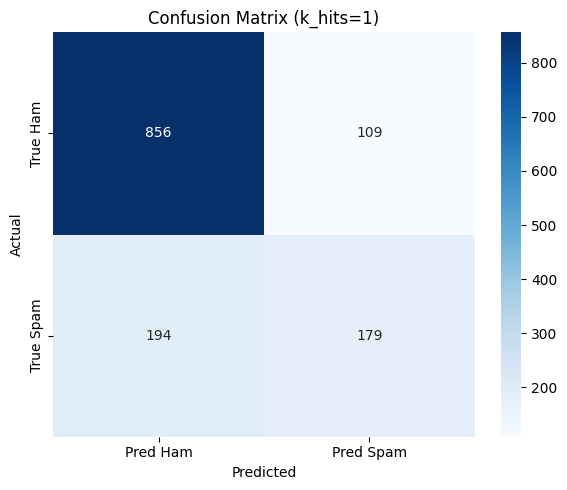


Classification Report:

              precision    recall  f1-score   support

         Ham       0.82      0.89      0.85       965
        Spam       0.62      0.48      0.54       373

    accuracy                           0.77      1338
   macro avg       0.72      0.68      0.70      1338
weighted avg       0.76      0.77      0.76      1338



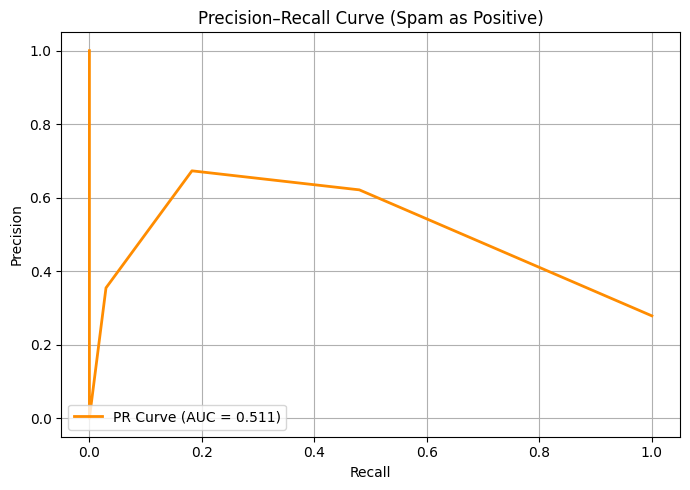


Precision–Recall AUC: 0.511


In [50]:
# === Predict ===
y_pred, scores = nsa.predict(X_eval, k_hits=best_hits, return_score=True)

# === Confusion Matrix ===
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=["True Ham", "True Spam"],
                     columns=["Pred Ham", "Pred Spam"])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (k_hits=1)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# === Classification Report ===
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=["Ham", "Spam"]))

# === Precision–Recall Curve ===
prec, rec, _ = precision_recall_curve(y_val, scores)
pr_auc = auc(rec, prec)

plt.figure(figsize=(7,5))
plt.plot(rec, prec, color="darkorange", linewidth=2,
         label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Spam as Positive)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nPrecision–Recall AUC: {pr_auc:.3f}")